<img src="images/for-sale-sign.png" />

# King County House Price Model
---
**Authors:** Wes Newcomb, Noble Tang, Kelsey Lane

## Overview
---
This project analyzes housing information drawn from the King County area from May 2014 to May 2015 in order to help real estate agencies determine how different metrics can impact the price of a home. After the data was cleaned and encoded, various iterative multiple linear regressions were run in order to converge on a model to use for the house price inference. It was found that the price of a given home in King County could be reasonably modeled using square footage of the house, the condition of the home, and if the house was in an urban, suburban, or rural area.

## Business Problem
---
This model was created for small real estate agencies in King County during 2016 to help them understand more about how altering certain features of a home could impact the resulting price range of the house. This can help give them insight into dynamics that might have been exclusive only to large companies that had access to this kind of analysis before and help make these smaller real estate agencies more competitive. By focusing in on how location, house condition, and square footage relate to price, real estate agencies can have a digestible understanding of some basic factors to focus on that can help improve their business.

## Data Understanding
---
This project uses a dataset containing information on 21,597 property sales in King County between May 2014 and May 2015 drawn from the [King County website](https://info.kingcounty.gov/assessor/esales/residential.aspx?openSearchForm=1). Each row represents a different sale and corresponding information about the property sold.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset into notebook
df = pd.read_csv('data/kc_house_data.csv')

# preview dataset
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The information provided includes details like the square footage of lot and living space, number of beds and bathrooms, the date the property was sold, sale price, number of floors in the house, if it was a waterfront property, the zip code the property is in, and other additional columns shown below.

In [2]:
# preview dataset columnar information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

As the model is predicting the price of future homes, price is the target variable used from the dataset. The distribution of the column can be seen below, where there is a right skew, indicating the presence of some very expensive homes in the dataset.

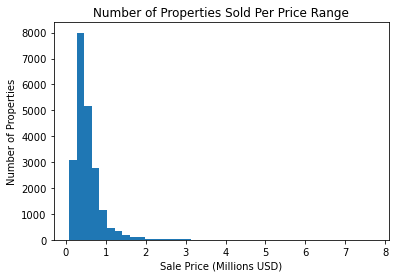

In [3]:
#Visualize home price data
ax1 = plt.axes()

(df['price']*(1/1000000)).hist(bins=40)

plt.ylabel('Number of Properties')
plt.xlabel('Sale Price (Millions USD)')
plt.title('Number of Properties Sold Per Price Range')
ax1.ticklabel_format(style='plain')
ax1.grid(False)

plt.show()

However, not all the information provided in the original dataset is used in the creation of the model. These factors aren't all significant in helping create an inference around home prices and thus it's beneficial to pair the dataset down to important points. Furthermore, the continuous features that correlate well with the target variable, price, while not correlating strongly with each other would make for viable features to use, as this shows they have some kind of correlation with price with not creating issues of multicollinearity. These features, like sqft_living and sqft_lot, can be seen in the below heatmap.

<AxesSubplot:>

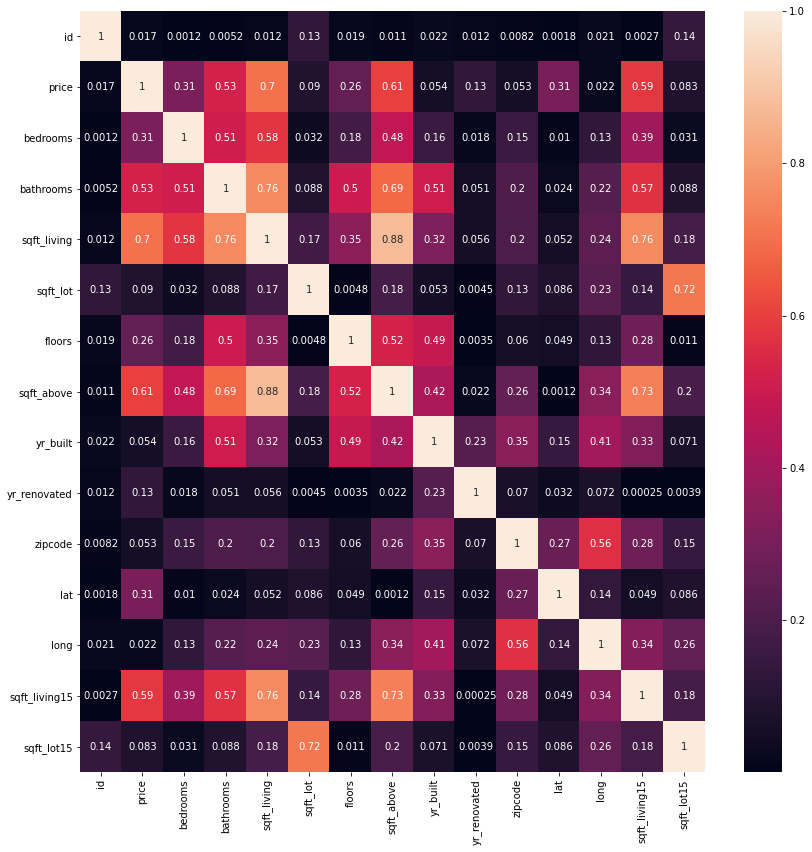

In [4]:
#Heatmap showing correlation with target and other continuous variables in dataset
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(df.corr().abs(), annot = True)

The data is also limited in it's distribution of information. For example, there are not a lot of higher priced homes included in the set, so the model could become more variable for higher priced homes as there's not enough data to help capture the relationship. Furthermore, the dataset is also limited in its quantity and number of features, which may also impact the model.

## Data Preparation
---

### Outliers

While most of the data was entered correctly, there does appear to be some mistyped entries. An example is shown below, where one property is listed with 33 bedrooms while only having 1,620 square feet of living space, which isn't possible.

In [5]:
#Information on the misentered house
df.iloc[15856]

id               2402100895
date              6/25/2014
price                640000
bedrooms                 33
bathrooms              1.75
sqft_living            1620
sqft_lot               6000
floors                    1
waterfront               NO
view                   NONE
condition         Very Good
grade             7 Average
sqft_above             1040
sqft_basement         580.0
yr_built               1947
yr_renovated              0
zipcode               98103
lat                 47.6878
long               -122.331
sqft_living15          1330
sqft_lot15             4700
Name: 15856, dtype: object

Similarly, there are examples of data where the total amount of living space (sqft_living) exceeds the lot space of the property, even when floors are taken into account. This isn't possible, as it would mean the house is bigger than the lot it resides on.

In [6]:
#Shows the houses with impossible sizes
df[(df['sqft_lot']) < (df['sqft_living'] / df['floors'])]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1547,8816400885,10/8/2014,450000.0,4,1.75,1640,1480,1.0,NO,NONE,...,7 Average,820,820.0,1912,0.0,98105,47.6684,-122.314,1420,2342
3449,2559950110,4/22/2015,1230000.0,2,2.50,2470,609,3.0,NO,NONE,...,11 Excellent,1910,560.0,2011,0.0,98112,47.6182,-122.312,2440,1229
5795,2770604103,7/31/2014,450000.0,3,2.50,1530,762,2.0,NO,NONE,...,8 Good,1050,480.0,2007,0.0,98119,47.6420,-122.374,1610,1482
13240,2877104196,12/6/2014,760000.0,3,2.00,1780,1750,1.0,NO,AVERAGE,...,8 Good,1400,380.0,1927,2014.0,98103,47.6797,-122.357,1780,3750
13265,3277800845,7/11/2014,370000.0,3,1.00,1170,1105,1.0,NaN,NONE,...,7 Average,1170,0.0,1965,0.0,98126,47.5448,-122.375,1380,1399
15729,9828702895,10/22/2014,700000.0,4,1.75,2420,520,1.5,NO,NONE,...,7 Average,2420,0.0,1900,0.0,98112,47.6209,-122.302,1200,1170
16917,5016002275,6/2/2014,610000.0,5,2.50,3990,3839,1.0,NaN,NONE,...,8 Good,1990,2000.0,1962,0.0,98112,47.6236,-122.299,2090,5000
17420,2062600020,7/8/2014,530000.0,2,2.50,1785,779,2.0,NO,NONE,...,7 Average,1595,190.0,1975,0.0,98004,47.5959,-122.198,1780,794


Due to the fact that these nine listings don't seem to be possible and are likely present in the dataset due to human error, they were dropped from the final dataset.

In [7]:
#Drops properties with more living space than possible
idx = df[(df['sqft_lot']) < (df['sqft_living'] / df['floors'])].index
df = df.drop(idx, axis=0)

#Drops property with 33 bedrooms and 1620 sqft_living
df = df.drop(15856, axis=0)

### Final Columns

As mentioned above, certain property features correlate better with price while avoiding multicollinearity issues. As a result, the dataset was paired down to only include the columns that would be of interest to both real estate agencies and potential to explain the variability in price: square foot living space, bedrooms, bathrooms, square footage of the lot, location (for now represented by zip code), home condition, and the year the house was built along if it was renovated.

In [8]:
#Drops the columns no longer needed
df = df.drop(columns = ['id', 'date', 'floors', 'waterfront', 'view', 'grade','lat', 
                        'long', 'sqft_basement', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

### Missing Data

After selecting the final columns, there is some missing data left in the year renovated column.

In [9]:
df.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
condition          0
yr_built           0
yr_renovated    3842
zipcode            0
dtype: int64

As it is unclear if the null values indicate that the house wasn't renovated or that this information just wasn't collected, the safest approach seems to be to fill the empty value with the median value, which in this case is 0 indicating the property wasn't renovated.

In [10]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.isna().sum()

price           0
bedrooms        0
bathrooms       0
sqft_living     0
sqft_lot        0
condition       0
yr_built        0
yr_renovated    0
zipcode         0
dtype: int64

### Column Creation

As location is one of the points of interest in the analysis and the zip code column has too many variables to reasonably encode for an inferential model, the zip codes are categorized by being in an urban, suburban, or rural area. The information for this zip code breakdown is drawn from the [King County site](https://kingcounty.gov/~/media/depts/executive/performance-strategy-budget/regional-planning/buildable-lands-report/king-county-buildable-lands-report-2014.ashx?la=en) itself, where rural areas are identified [through this webpage](https://web.archive.org/web/20150911054310/https://kingcounty.gov/services/rural-services/rural/community.aspx) and the mapping of rural, suburban, and urban areas to zip code is obtained by comparing the first map to [the map of zip codes](https://kingcounty.gov/~/media/operations/GIS/maps/vmc/images/zipcodes_westKC_586.ashx?la=en%20-%20zipcode%20to%20place).

In [11]:
#Makes the zip code to location dictionary
zip_class = {
            98002 : 'Urban', 98092 : 'Urban', 98178: 'Urban', 98125: 'Urban', 98028:'Suburban',
            98136: 'Urban', 98074: 'Suburban', 98053: 'Urban', 98003: 'Urban',
            98198: 'Suburban', 98146: 'Urban', 98038: 'Suburban', 98007:'Urban', 98115:'Urban',
            98107:'Urban', 98126:'Urban', 98019:'Rural', 98103:'Urban', 98133:'Urban', 98030: 'Urban',
            98119:'Urban', 98112:'Urban', 98052:'Urban', 98027:'Suburban', 98117:'Urban', 98058:'Urban',
            98001:'Urban', 98056:'Urban', 98166:'Urban', 98023:'Urban', 98070:'Rural',
            98148:'Urban', 98105:'Urban', 98042:'Suburban', 98008:'Urban', 98059:'Urban', 98122:'Urban',
            98144:'Urban', 98004:'Urban', 98005:'Urban', 98034:'Urban', 98075:'Suburban',98116:'Urban',
            98010:'Rural', 98118:'Urban', 98199:'Urban', 98040:'Suburban', 98032:'Urban',
            98045:'Rural', 98102:'Urban', 98077:'Rural', 98108:'Urban', 98168:'Urban',
            98177:'Suburban', 98065:'Rural', 98029:'Suburban', 98006:'Urban', 98109:'Urban', 98022:'Rural',
            98033:'Urban', 98155:'Suburban', 98024:'Rural', 98011:'Urban', 98031:'Urban',
            98106:'Urban', 98072:'Suburban', 98188:'Urban', 98014:'Rural', 98055:'Urban', 98039:'Suburban'
            }
#Creates area column and assigns appropriate value based on zipcode
df['area_type'] = df['zipcode']
df['area_type'] = df['area_type'].map(zip_class)

#Drops zip code as it is no longer needed
df = df.drop('zipcode', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,yr_built,yr_renovated,area_type
0,221900.0,3,1.00,1180,5650,Average,1955,0.0,Urban
1,538000.0,3,2.25,2570,7242,Average,1951,1991.0,Urban
2,180000.0,2,1.00,770,10000,Average,1933,0.0,Suburban
3,604000.0,4,3.00,1960,5000,Very Good,1965,0.0,Urban
4,510000.0,3,2.00,1680,8080,Average,1987,0.0,Suburban


When renovation is considered in the iterative models below, it is treated as a true/false value where only the fact that the house was renovated matters. This is to help keep the model simple and also because it is ambiguous over how renovations could be accurately binned without introducing any confounding factors.

In [12]:
#Makes list to store if the house was renovated
is_renovated = []

#Cycles through the year renovated column and adds a one if the house was renovated, 0 if not
for value in df['yr_renovated']:
    if value > 0:
        is_renovated.append(1)
    else:
        is_renovated.append(0)

#Creates column denoting if house was or wasn't renovated and removes yr_renovated
df['is_renovated'] = is_renovated
df = df.drop('yr_renovated', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,yr_built,area_type,is_renovated
0,221900.0,3,1.00,1180,5650,Average,1955,Urban,0
1,538000.0,3,2.25,2570,7242,Average,1951,Urban,1
2,180000.0,2,1.00,770,10000,Average,1933,Suburban,0
3,604000.0,4,3.00,1960,5000,Very Good,1965,Urban,0
4,510000.0,3,2.00,1680,8080,Average,1987,Suburban,0


The final column created was a bin for house condition. In order to make the results clearer, poor, fair, and average results were binned together, as these represented houses that would need some amount of maintence still [according to the King County site](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r). Good and Very Good results are kept seperate as they have a clearer deliniation about maintence of the house. By binning condition this way, it helps narrow condition down to more pertinent features.

In [13]:
#Function to bin house conditions together
def bin_conditions(x):
    if (x == 'Poor') | (x == 'Fair') | (x == 'Average'):
        return 'Low'
    elif x == 'Good':
        return 'Medium'
    else:
        return 'High' 

#Bins conditions by the three groups above
df['conditions_bin'] = df['condition'].apply(bin_conditions)
df = df.drop('condition', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,area_type,is_renovated,conditions_bin
0,221900.0,3,1.00,1180,5650,1955,Urban,0,Low
1,538000.0,3,2.25,2570,7242,1951,Urban,1,Low
2,180000.0,2,1.00,770,10000,1933,Suburban,0,Low
3,604000.0,4,3.00,1960,5000,1965,Urban,0,High
4,510000.0,3,2.00,1680,8080,1987,Suburban,0,Low


## Baseline Model
---

The baseline used for comparison of the models is the mean of the price. This is the simplest predictor, and thus works as a good measure of comparison to see if the future models have any kind of inferential power. The R2 for the baseline is around -5.6 x 10^-5, indicating a very small number that does not really explain any of the variability in price.

In [14]:
from sklearn.dummy import DummyRegressor

#Df to sample from for training and testing set
df_sample = df

df_train = df_sample.sample(frac=0.5, random_state=2)
df_test = df_sample.drop(df_train.index)

X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)
print("Baseline R2: " + str(dummy_regr.score(X_test, y_test)))

Baseline R2: -5.592480262373023e-05


## Modeling and Evaluation
---

In order to make the modeling more efficient, the function below is used to generate the models. Briefly, it takes in a train-test split, if the independant variables are going to be scaled, and the names of continuous variables to know which columns to scale if appliable. The necessary inputs are then scaled if needed, the model is generated, the assumption tests are run, and the final model is returned.

In [15]:
#Imports necessary functions
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None

def model_maker(X_train, X_test, y_train, y_test, X_cont, scale = True):
    #Gets figures ready for plotting
    fig, axes = plt.subplots(nrows = 2, figsize = (12,12))
    
    #Scales data if needed
    if scale == True:
        scalar = StandardScaler()
        X_train[X_cont] = scalar.fit_transform(X_train[X_cont])
        X_test[X_cont] = scalar.transform(X_test[X_cont])
    
    #Makes model
    X_const = sm.add_constant(X_train)
    linreg_model = sm.OLS(y_train, X_train).fit()
    
    #Grabs predictions
    train_predict = linreg_model.predict(X_train)
    test_predict = linreg_model.predict(X_test)
    
    #Prints MSE
    print("Train MSE: " + str(mean_squared_error(y_train, train_predict)))
    print("Test MSE: " + str(mean_squared_error(y_test, test_predict)))
    
    #Creates residuals
    train_resid = y_train - train_predict
    test_resid = y_test - test_predict
    
    #Test for normality
    sm.qqplot(train_resid, line = 'r', ax = axes[0])
    
    #Test for heteroskedasticity
    model = Ridge()
    visualizer = ResidualsPlot(model, ax = axes[1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
     
    return linreg_model

### First model
The first model looks at two features that come up frequently when talking about real estate - square foot living space and number of bathrooms.

Train MSE: 365204642459.9775
Test MSE: 350703089728.4005


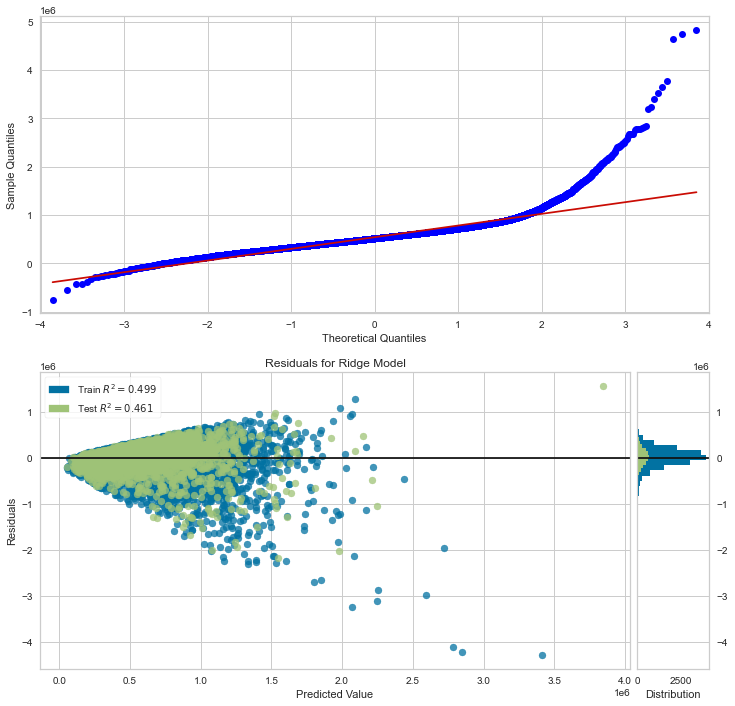

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.160
Model:                            OLS   Adj. R-squared (uncentered):              0.160
Method:                 Least Squares   F-statistic:                              1646.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:54   Log-Likelihood:                     -2.5440e+05
No. Observations:               17270   AIC:                                  5.088e+05
Df Residuals:                   17268   BIC:                                  5.088e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms   -4417.6539   7050.011     -0.627      0.531   -1.82e+04    9401.082
sqft_living  2.672e+05   7050.011     37.898      0.000    2.53e+05    2.81e+05
==============================================================================
Omnibus:                    12148.279   Durbin-Watson:                   0.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483241.210
Skew:                           2.903   Prob(JB):                         0.00
Kurtosis:                      28.256   Cond. No.                         2.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
#Grabs continuous variable names
features_of_interest = ['bathrooms', 'sqft_living']

#Creates independant and dependant variables
X_df = df[features_of_interest]
y_df = df['price']

#Train test splits the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Makes the model and runs assumption tests
first_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
first_model.summary()

### Second model
While the Adjusted R2 value for this first model is better than the baseline, bathrooms does not seem to be a significant predictor despite correlating well with price. Therefore, the next model swaps out bathrooms for bedrooms as a predictor, which is another important factor to consider when looking at home price.

Train MSE: 362989735310.17664
Test MSE: 348310084760.0081


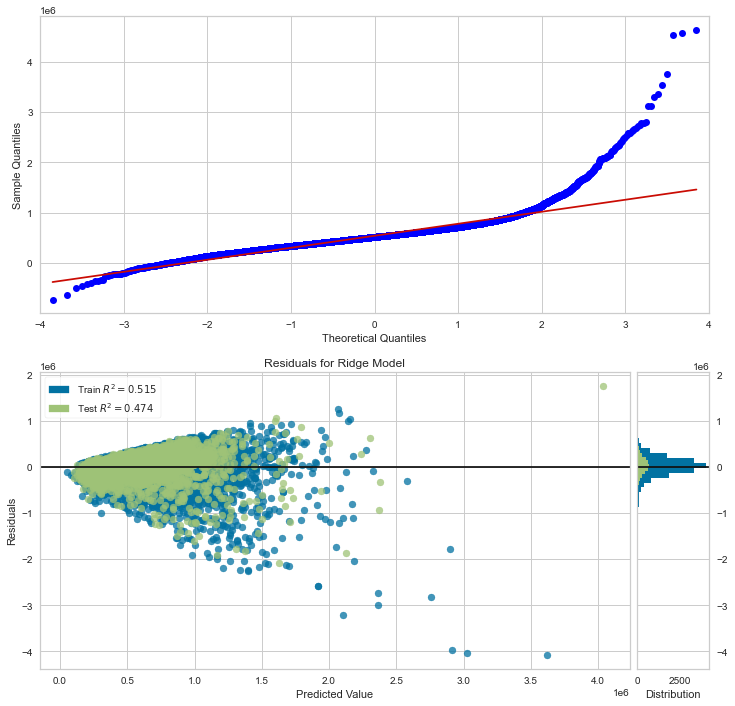

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.165
Model:                            OLS   Adj. R-squared (uncentered):              0.165
Method:                 Least Squares   F-statistic:                              1709.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:55   Log-Likelihood:                     -2.5435e+05
No. Observations:               17270   AIC:                                  5.087e+05
Df Residuals:                   17268   BIC:                                  5.087e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living  2.985e+05   5689.039     52.464      0.000    2.87e+05     3.1e+05
bedrooms    -5.851e+04   5689.039    -10.284      0.000   -6.97e+04   -4.74e+04
==============================================================================
Omnibus:                    11750.041   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           425990.817
Skew:                           2.790   Prob(JB):                         0.00
Kurtosis:                      26.683   Cond. No.                         1.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
#The features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

#New independant variable dataframe
X_df = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

second_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
second_model.summary()

### Third model
While the adujsted R2 value is only slightly better than the first model, both coefficients this time are significant. Therefore, this model is the one iterated on as it includes the two coefficients that correlate highly with price and can help real estate agencies get a deeper grip on how changing these factors may impact price range. From here, the next model includes location in an effort to better explain the variability in price and thus improve the adjusted R2 score. This also improves its usefulness for home buyers looking for a house in a specific type of area. As location is treated as a categorical variable, it is one hot encoded and the rural column is dropped to avoid multicollinearity issues.

Train MSE: 118549236782.18959
Test MSE: 111929070343.02814


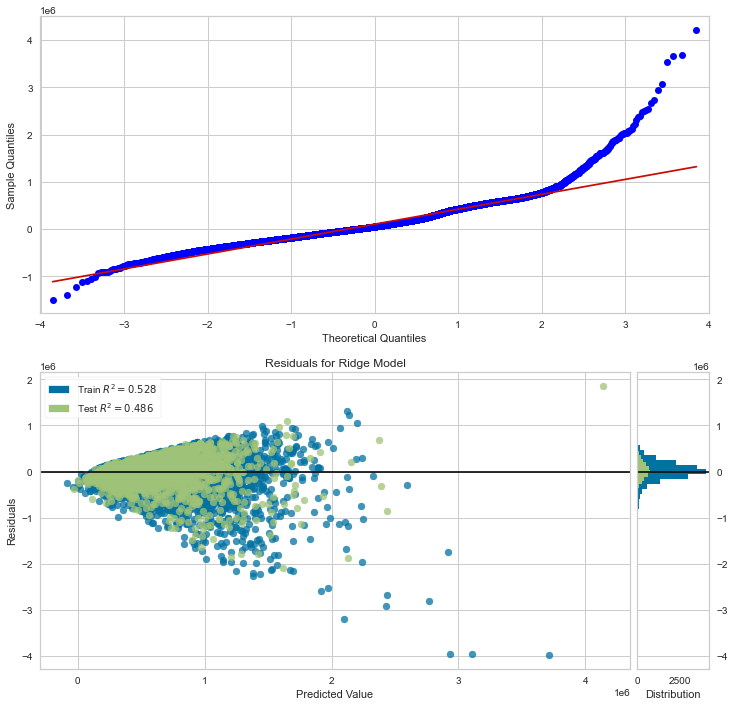

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                          1.152e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:55   Log-Likelihood:                     -2.4469e+05
No. Observations:               17270   AIC:                                  4.894e+05
Df Residuals:                   17266   BIC:                                  4.894e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
area__Rural  4.129e+05   9633.897     42.863      0.000    3.94e+05    4.32e+05
area__Urban  5.704e+05   3108.185    183.504      0.000    5.64e+05    5.76e+05
sqft_living  3.356e+05   3271.920    102.566      0.000    3.29e+05    3.42e+05
bedrooms    -6.312e+04   3258.593    -19.369      0.000   -6.95e+04   -5.67e+04
==============================================================================
Omnibus:                     6123.024   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54454.732
Skew:                           1.452   Prob(JB):                         0.00
Kurtosis:                      11.200   Cond. No.                         4.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#The features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

#Categorical data that we want to include in our model
city_df = pd.get_dummies(df['area_type'], prefix='area_')
city_df = city_df.drop(columns = 'area__Suburban')

#Creates new dataframe of independant variables
X_df = pd.concat([city_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

third_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
third_model.summary()

### Fourth model
This third model has a drastic increase in the adjusted R2 value, hopping up from around 16% to now explaining almost 82% of the variability in price. All coefficients also remain significant, indicating they would be good predictors to use. However, there are issues with both the homoskedasticity and normality assumptions. In an effort to address this, the next model eliminates houses with a price outside three standard deviations from the mean based on the training data from both the train and test sets. This should help decrease the effect of home price outliers on the data and help correct some issues with the model.

Train MSE: 103656106075.60287
Test MSE: 104120129333.8636


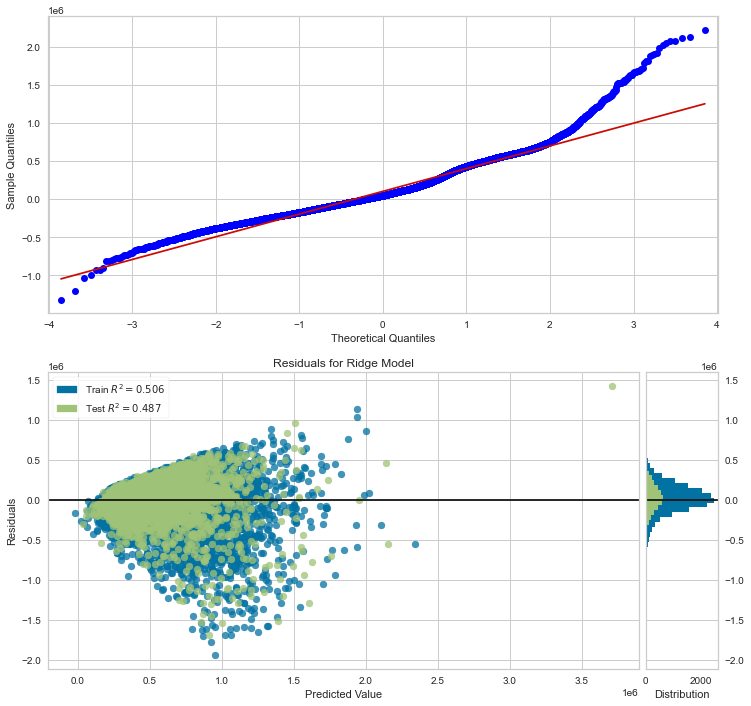

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.734
Method:                 Least Squares   F-statistic:                          1.190e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:56   Log-Likelihood:                     -2.4279e+05
No. Observations:               17218   AIC:                                  4.856e+05
Df Residuals:                   17214   BIC:                                  4.856e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
area__Rural  4.172e+05   9012.912     46.284      0.000    3.99e+05    4.35e+05
area__Urban   5.58e+05   2911.291    191.652      0.000    5.52e+05    5.64e+05
sqft_living  2.885e+05   3071.659     93.935      0.000    2.83e+05    2.95e+05
bedrooms    -5.003e+04   3057.629    -16.361      0.000    -5.6e+04    -4.4e+04
==============================================================================
Omnibus:                     2927.221   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7131.709
Skew:                           0.958   Prob(JB):                         0.00
Kurtosis:                       5.504   Cond. No.                         4.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#The continuous features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

X_df = pd.concat([city_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Merges training and testing sets together
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#Finds the price cutoff based on training and applies to both train/test sets
price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

#Splits data back in x and y
X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

fourth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
fourth_model.summary()

### Fifth model
This fourth model shows a slight increase in adjusted R2 after cutting out the outliers, increasing by around 2%. Furthermore, compared to the third model with the same predictors, there is a lower mean squared error with less of a difference between the training and test sets, indicating this model is a bit more accurate than the older one. However, the metric for bedrooms is unintuitive for an inference model like this. Therefore, other  metrics were tested to see how they would impact price. As home condition is another factor real estate agencies could consider when looking at homes, it was substituted for bedrooms to see how it would impact the model. 

Train MSE: 97965821583.35643
Test MSE: 98179373271.56749


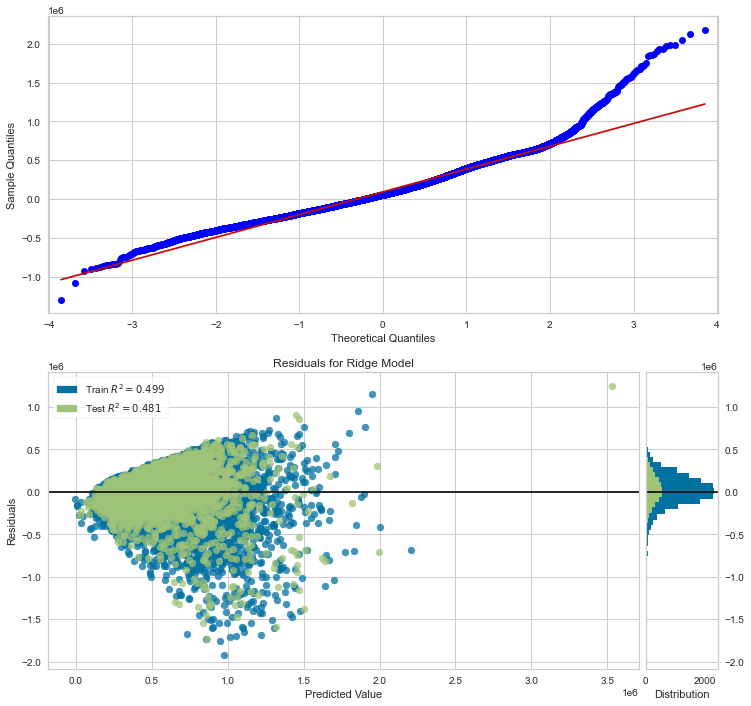

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                          1.028e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:57   Log-Likelihood:                     -2.4231e+05
No. Observations:               17218   AIC:                                  4.846e+05
Df Residuals:                   17213   BIC:                                  4.847e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
area__Rural   3.802e+05   8842.925     42.999      0.000    3.63e+05    3.98e+05
area__Urban   4.947e+05   3324.418    148.798      0.000    4.88e+05    5.01e+05
cond__High    2.104e+05   8985.391     23.415      0.000    1.93e+05    2.28e+05
cond__Medium  1.609e+05   5316.909     30.257      0.000     1.5e+05    1.71e+05
sqft_living   2.626e+05   2401.788    109.350      0.000    2.58e+05    2.67e+05
==============================================================================
Omnibus:                     2618.193   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6511.337
Skew:                           0.859   Prob(JB):                         0.00
Kurtosis:                       5.474   Cond. No.                         4.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
#Features we are interested in for this model
features_of_interest = ['sqft_living']

#categorical data that we want to include in our model
condition_df = pd.get_dummies(df['conditions_bin'], prefix='cond_')
#Drops a column to avoid issues in the model
condition_df = condition_df.drop(columns = 'cond__Low')

X_df = pd.concat([city_df, condition_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#filtering out the high priced homes. we want the lower 97.5%
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

fifth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
fifth_model.summary()

### Sixth model
While the fifth model has a drop of .1% in the adujsted R2 value, the resulting model is more intuitive of an explanation for real estate agencies. However, while this is the final model settled on, further iterations were done with other inputs to see if there would be a pursuable increase in adjusted R2 with different metrics as well. For the sake of brevity, only one of the models is included as none of them are further pursued.

Train MSE: 95890428030.35956
Test MSE: 96919709464.90942


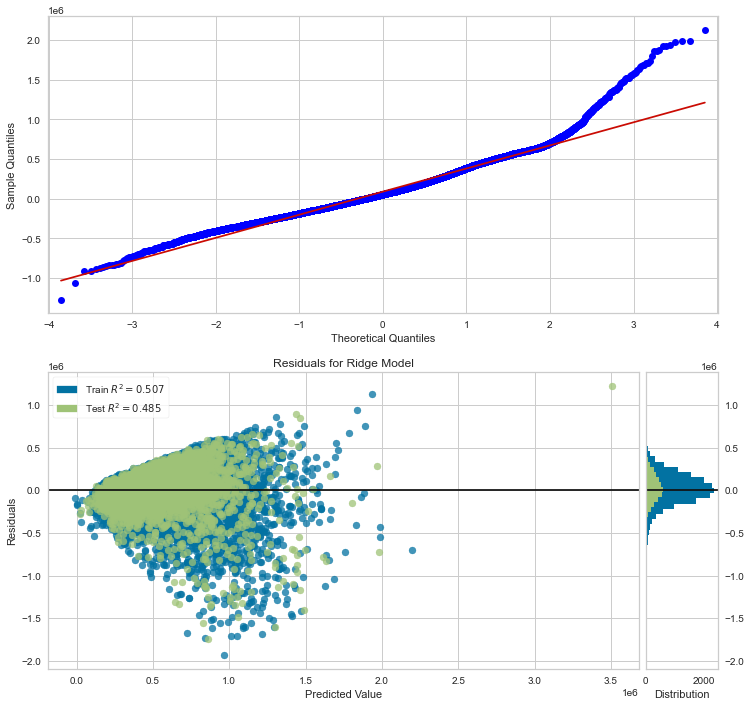

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.754
Model:                            OLS   Adj. R-squared (uncentered):              0.754
Method:                 Least Squares   F-statistic:                              8810.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:58   Log-Likelihood:                     -2.4212e+05
No. Observations:               17218   AIC:                                  4.843e+05
Df Residuals:                   17212   BIC:                                  4.843e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
area__Rural   3.719e+05   8759.579     42.461      0.000    3.55e+05    3.89e+05
area__Urban    4.84e+05   3334.936    145.140      0.000    4.77e+05    4.91e+05
cond__High    2.147e+05   8892.806     24.146      0.000    1.97e+05    2.32e+05
cond__Medium  1.643e+05   5263.453     31.217      0.000    1.54e+05    1.75e+05
sqft_living     2.6e+05   2380.088    109.256      0.000    2.55e+05    2.65e+05
is_renovated   2.53e+05   1.31e+04     19.301      0.000    2.27e+05    2.79e+05
==============================================================================
Omnibus:                     2446.281   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5911.339
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                       5.359   Cond. No.                         5.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#Features we are interested in for this model
features_of_interest = ['sqft_living']

X_df = pd.concat([city_df, condition_df, df[features_of_interest], df['is_renovated']], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#filtering out the high priced homes. we want the lower 97.5%
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

sixth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
sixth_model.summary()

## Final Model Evaluation
---

As mentioned earlier, the fifth model is the final model used as further iterations did not show a big enough increase in R2 to consider pursuing further. For interpretability, the fifth model is again included below, but this time with the continuous variable being unscaled. The takeaway for this model seems to be that location, square foot living space, and condition of the home can be used to explain around 75% of the variability of price for homes in King County from 2014-2015. This is an improvement on the baseline, where the R2 score was quite small, indicating this model does a much better job of explaining the variability. With everything else held steady, an increse in 1 sqaure foot living space increases price by around 247 dollars. Other factors still held constant, living in an urban rather than suburban area increases price by 25,670 dollars and living in a rural area rather than suburban decreases price by 88,320 dollars. Of these factors, location is the most significant predictor, followed by square foot living and then home condition.

When it comes to the model assumptions, the model does not do that well. While linearity and multicollinearity are checked before with the correlation plot and are accounted for, the QQ plot showing normality still has issues at the tail ends despite culling out outliers. Similarly, the plot looking at heteroskedasticity retains a cone shape, indiacting issues there as well.

While this is a decent fit for the dataset provided, it isn't clear how well it would generalize to different areas and different time periods, as house prices and price distribution would be affected by these factors. Furthermore, the fact that the model does not fullfill the assumptions would also make it inaccurrate in more rigorous price inferences. As for how beneficial this model is for the stakeholders, given the adjusted R2 score of 75%, it would do a decent job at helping predict home prices variability for real estate agencies in King County.

Train MSE: 53075303270.23432
Test MSE: 54786684337.00616


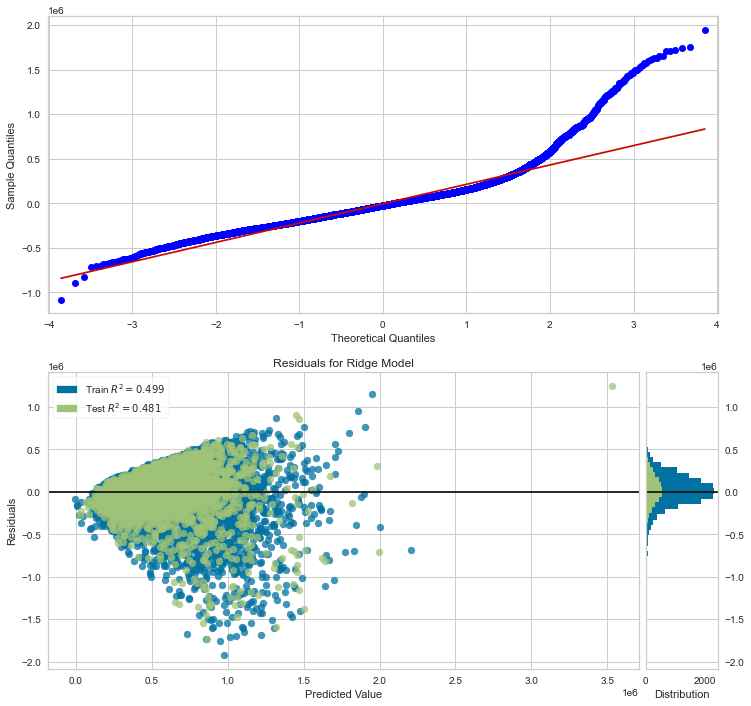

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                          2.188e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:22:58   Log-Likelihood:                     -2.3703e+05
No. Observations:               17218   AIC:                                  4.741e+05
Df Residuals:                   17213   BIC:                                  4.741e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
area__Rural  -8.832e+04   7061.421    -12.507      0.000   -1.02e+05   -7.45e+04
area__Urban   2.567e+04   3399.205      7.552      0.000     1.9e+04    3.23e+04
cond__High    9.068e+04   6638.249     13.660      0.000    7.77e+04    1.04e+05
cond__Medium    1.9e+04   3950.004      4.810      0.000    1.13e+04    2.67e+04
sqft_living    247.8315      1.295    191.388      0.000     245.293     250.370
==============================================================================
Omnibus:                     7046.745   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53585.263
Skew:                           1.785   Prob(JB):                         0.00
Kurtosis:                      10.871   Cond. No.                     9.30e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
#Features we are interested in for this model
features_of_interest = ['sqft_living']

X_df = pd.concat([city_df, condition_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#filtering out the high priced homes. we want the lower 97.5%
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

final_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest, scale = False)
final_model.summary()

## Conclusions
---
When real estate agencies are looking at home price inferences during this timeframe, the location and square foot living space are the most important factors that could impact home price, followed by the home condition. Therefore, when considering the price range of houses a real estate agency is looking for, these factors can help give a more numeric understanding of variability in price range.

Limitations of this data are obviously the timeframe and location, as home price prediction would vary based on these factors so this model wouldn't be applicable outside of this consideration. Building on that, the model is unstable for homes of a higher price and actually cuts off high-priced outliers, so buyers looking for more expensive or extravegant houses wouldn't get accurrate results. The model also doesn't include all the variables, so there may be factors influencing price that are overlooked.

Finally, going forward it would be good to work with more data from different areas to see if the model could be adapted to different locations, as well as integrating data from more recent years and a more robust number of features.